In [7]:
from __future__ import division
import numpy as np
from numpy.random import choice, dirichlet, binomial, multinomial, beta, gamma, normal, exponential, multivariate_normal#, gaussian
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle as pkl 
import pdb


In [2]:
import csv
def read_data(file_path):
    # The read-in data should be a N*W matrix,
    # where N is the length of the time sequences,
    # W is the number of sensors/data features
    i = 0
    with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter = ',')
        for line in reader:
            line = np.array(line, dtype = 'float') # str2float
            if i == 0:
                data = line
            else:
                data = np.vstack((data, line))
            i += 1
    return data

In [3]:
# generate stick-breaking
def GEM(gma):
    beta_product = 1
    while True:
        beta_k = beta(1,gma)
        pi_k = beta_k * beta_product
        beta_product *= (1-beta_k)
        yield pi_k
        

[ 0.00285224  0.01928198  0.0176008   0.00021613  0.00133183  0.00354572
  0.00546871  0.01156271  0.00395281  0.02242231  0.0047793   0.01269407
  0.02446767  0.00517254  0.01030405  0.01215745  0.00063854  0.0189667
  0.02298218  0.02081548]
('pi:', array([  9.64916212e-02,   8.62437610e-02,   3.32403191e-02,
         5.73027391e-06,   1.35403204e-03,   1.23511389e-02,
         4.22707556e-02,   3.26046050e-02,   1.72155325e-02,
         5.54509438e-02,   8.20589878e-03,   1.12661558e-01,
         1.15888595e-01,   2.42027937e-02,   4.42269408e-02,
         4.37802282e-02,   4.37971426e-11,   9.55801924e-02,
         1.40093821e-01,   3.81315326e-02]))


<function matplotlib.pyplot.show>

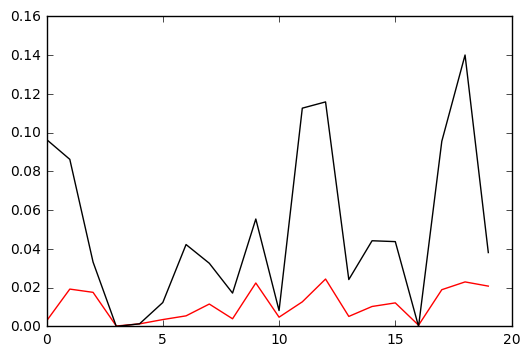

In [3]:
d_max = 20 # maximum number of state

gma = 100 # parameter for GEM distribution
stick_breaking = GEM(gma)
beta_gem = np.array([next(stick_breaking) for i in range(d_max)])
print (beta_gem)
plt.plot(range(d_max), beta_gem,'r')
plt.show

alpha = 100 # concentration parameter for DP
pi = dirichlet(alpha*beta_gem)
print ("pi:", pi)
plt.plot(range(d_max), pi,'k')
plt.show
# G0 = beta_gem*gamma()


In [3]:
class DirichletProcess():
    def __init__(self, data,max_k=20,gma=1,alpha=1,kappa=1,nu=2,sigma_a=2,sigma_b=2,kmeans_init=True):
        self.data = data
        
        self.n = data.shape[0] # number of data instances
        self.d = data.shape[1] # number of data dimensions
        
        self.alpha = alpha
        self.kappa = kappa * self.n
        self.nu = nu
        self.a = sigma_a
        self.b = sigma_b
        
        # max number of clusters
        self.max_k = max_k
        # randomly initialize states of the data
        if kmeans_init:
#             self.state = np.reshape(kmeans2(self.data.ravel(), self.max_k)[1], self.data.shape)# single variable
#             self.state = np.reshape(kmeans2(self.data, self.max_k)[1], (self.data.shape[0],1)) # multi variable
            self.state = kmeans2(self.data, self.max_k)[1]
        else:
#             self.state = choice(self.max_k,self.data.shape) # single variable
#             self.state = choice(self.max_k,(self.data.shape[0],1)) # multi variable
            self.state = choice(self.max_k,self.data.shape[0])
        # compute parameter for each cluster
#         std = np.std(self.data)
#         self.mu = normal(0, std, self.max_k)
#         self.sigma = np.ones(self.max_k)*std
        self.mu = []
        self.sigma = []
        for k in range(self.max_k):
            idx = np.where(self.state==k)[0] # multi variable
            nc = len(idx)
#             if idx[0].size:# single variable
            if nc:# multi variable
#                 cluster = self.data[idx,:]# single variable
                cluster = np.reshape(self.data[idx,:],(nc,self.d))
#                 self.mu[k] = np.mean(cluster) # single variable
                self.mu.append(np.mean(cluster,0)) # multi variable
#                 self.sigma[k] = np.std(cluster) # single variable
                if nc > 1:
                    self.sigma.append(np.cov(cluster,rowvar=False)) # multi variable
                else:
                    self.sigma.append(np.eye(self.d))
            else:
                cluster = []
#                 self.mu[k] = normal(0, np.sqrt(self.nu)) # single variable
                self.mu.append(multivariate_normal(np.zeros(self.d), np.eye(self.d))) # multi variable
#                 self.sigma[k] = 1 / gamma(self.a, self.b) # single variable
                self.sigma.append(np.eye(self.d)) # multi variable
        
        # stick-breaking construction
        self.gma = gma # parameter for GEM distribution
        self.stick_breaking = self.GEM()
        self.beta = np.array([next(self.stick_breaking) for i in range(self.max_k)]) # the weights of samples.
        
        # initialize the transition matrix
        self.N = np.zeros((self.max_k, self.max_k))
        for i in range(1, self.n):
#             for j in range(self.d):
#                 self.N[self.state[i-1,j], self.state[i,j]] += 1
            self.N[self.state[i-1], self.state[i]] += 1
        self.pi = (self.N.T/(np.sum(self.N, axis=1)+1e-7)).T
        
        # hierarchical construction
#         self.G0 = np.zeros(self.max_k)
#         self.Gj = np.zeros((self.max_k, self.max_k))
        
        
        
        self.log_likelihood_list = []
    def log_likelihood(self,x,mu,sigma):
#         return (-1/2) * ((x-mu)/sigma)**2 - np.log(np.sqrt(2*np.pi)*sigma) # single variable
        # multi variable
        if isinstance(mu,list):
            prob_list = []
            for i, _mu in enumerate(mu):
                diff = np.reshape(x-_mu,(1,self.d))
                prob = (-1/2) * np.dot(np.dot(diff, np.linalg.pinv(sigma[i])), diff.T) - np.log(np.sqrt(np.linalg.det(2*np.pi*sigma[i])))
                prob_list.append(float(prob))
            return np.array(prob_list)
        else:
            diff = np.reshape(x-mu,(1,self.d))
            prob = (-1/2) * np.dot(np.dot(diff, np.linalg.pinv(sigma)), diff.T) - np.log(np.sqrt(np.linalg.det(2*np.pi*sigma))) # multi variable
            return float(prob)
        
    def GEM(self):
        beta_product = 1
        while True:
            beta_k = beta(1,self.gma)
            pi_k = beta_k * beta_product
            beta_product *= (1-beta_k)
            yield pi_k
        
    def run(self):
#         pdb.set_trace()
        # Step 1, forward-backward algorithm
        forward,backward = self.message_passing()
        
        # Step 2, Metropolis-Hasting algorithm for state update
        self.MH_sampling(forward, backward)
        
        # step 3, run HDP
        self.HDP()
        
        # check log likelihood
        emis = 0
        trans = 0
        for t in range(self.n):
#             emis += self.log_likelihood(self.data[t,:], self.mu[self.state[t,:]], self.sigma[self.state[t,:]])
            emis += self.log_likelihood(self.data[t,:], self.mu[self.state[t]], self.sigma[self.state[t]])
            if t > 0:
#                 trans += np.log(self.pi[self.state[t-1,:],self.state[t,:]])
                trans += np.log(self.pi[self.state[t-1],self.state[t]])
#                 print ("data t: ", self.data[t,:])
#                 print ("mu: ", self.mu[self.state[t, :]])
#                 print ("sigma: ", self.sigma[self.state[t, :]])
#                 print ("state t-1:", self.state[t-1,:])
#                 print ("state t:", self.state[t,:])
#                 print ("pi (t-1,t): ", self.pi[self.state[t - 1, :], self.state[t, :]])
#                 input("continue...")
#                 print ("emis:", emis)
#                 print ("trans:", trans
        if np.isnan( emis+trans):
            print ("emis is:", emis)
            print ("trans is:", trans)
        self.log_likelihood_list.append(emis+trans)
#         print ("emis:",emis)
#         print ("trans:",trans)
        return emis+trans
    
    def message_passing(self):
        # forward
        alpha = np.zeros((self.n, self.max_k))
        alpha[0, :] = 1
        for t in range(1, self.n):
            alpha[t,:] = (self.pi.dot(alpha[t-1,:])) * np.exp(self.log_likelihood(self.data[t,:], self.mu, self.sigma))
#             alpha[t-1, :] /= np.max(alpha[t-1, :])
        # backward
        beta = np.zeros((self.n, self.max_k))
        beta[-1, :] = 1
        for t in range(self.n - 1, 0, -1):
            beta[t-1, :] = self.pi.dot(beta[t, :] * np.exp(self.log_likelihood(self.data[t,:], self.mu, self.sigma)))
#             beta[t-1, :] /= np.max(beta[t-1, :])
                        
        return alpha, beta
        
    def MH_sampling(self, alpha, beta):
        for t in range(1,self.n):
            # propose a candidate
            j = choice(self.max_k)
#             k = self.state[t,:]
            k = self.state[t] # multi variable
            # alpha[t-1,j] *
            # alpha[t-1,k] *
#             num =  alpha[t-1,j] *beta[t,j] * self.pi[self.state[t-1,:],j] * np.exp(self.log_likelihood(self.data[t,:], self.mu[j], self.sigma[j]))
#             den =  alpha[t-1,k] *beta[t,k] * self.pi[self.state[t-1,:],k] * np.exp(self.log_likelihood(self.data[t,:], self.mu[k], self.sigma[k]))
                                       
#             acceptance = 1 if num/den >1 or den == 0 else num/den
#             u = np.random.rand(1)
#             if u < acceptance:
#                 self.state[t,:] = j
#                 self.N[self.state[t-1, :], j] += 1
#                 self.N[self.state[t-1, :], k] -= 1
            logprob_accept = (#np.log(alpha[t-1,k]) -
                              #np.log(alpha[t-1,j]) +
                              np.log(beta[t, k]) -
                              np.log(beta[t, j]) +
#                               np.log(self.pi[self.state[t-1, :], k]) - # single variable
#                               np.log(self.pi[self.state[t-1, :], j]) + # single variable
                              np.log(self.pi[self.state[t-1], k]) - # multi variable
                              np.log(self.pi[self.state[t-1], j]) + # multi variable
                              self.log_likelihood(self.data[t-1, :], 
                                                  self.mu[k], 
                                                  self.sigma[k]) -
                              self.log_likelihood(self.data[t-1, :], 
                                                  self.mu[j], 
                                                  self.sigma[j]))
            if exponential(1) > logprob_accept:
                print ("state update!")
                self.state[t] = j
                self.N[self.state[t-1], j] += 1
                self.N[self.state[t-1], k] -= 1
                        
    def HDP(self):
#         stick_breaking = GEM(self.gma)
#         self.G0 = np.array([next(stick_breaking) for i in range(self.max_k)]) # the weights of samples.
        
        # draw beta from G0, place a dirichlet prior on beta with symmetric parameters
        self.beta = dirichlet(np.ones(self.max_k)* (self.gma/self.max_k))
#         stick_breaking = self.GEM()
#         self.beta = np.array([next(stick_breaking) for i in range(self.max_k)])
        
        # draw pi from Gj, place a dirichlet prior on pi with beta as base measure.
        tmp = np.tile(self.alpha * self.beta,(self.max_k,1)) + self.N
        np.fill_diagonal(tmp, np.diag(tmp) + self.kappa)
        for j in range(self.max_k):
            self.pi[j,:] = dirichlet(tmp[j,:])
            idx = np.where(self.state == j)[0] # multi variable
#             cluster = self.data[idx,:] # sigle variable
#             nc = cluster.size # sigle variable
            nc = len(idx) # multi variable
            
            if nc:
                cluster = np.reshape(self.data[idx,:],(nc,self.d)) # multi variable
#                 tmp_mu = np.mean(cluster) # single variable
#                 tmp_sigma = np.var(cluster) # single variable
                tmp_mu = np.mean(cluster,0) # multi variable
                if nc >1:
                    tmp_sigma = np.cov(cluster, rowvar=False) # multi variable
                else:
                    tmp_sigma = np.eye(self.d)
#                 self.mu[j] = tmp_mu / (self.nu / nc + 1)
#                 self.sigma[j] = (2 * self.b + (nc - 1) * tmp_sigma + 
#                                  nc * tmp_mu ** 2 / (self.nu + nc)) / (2 * self.a + nc - 1)
                self.mu[j] = tmp_mu
                self.sigma[j] = tmp_sigma
            else:
#                 self.mu[j] = normal(0, np.sqrt(self.nu))
#                 self.sigma[j] = 1 / gamma(self.a, self.b)
                
                self.mu[j] = multivariate_normal(np.zeros(self.d), np.eye(self.d))
                self.sigma[j] = np.eye(self.d)
                
    def get_path(self):
        path = np.zeros(self.data.shape)
        for k,mu in enumerate(self.mu):
            path[np.where(self.state==k)] = mu
        return path

<function matplotlib.pyplot.show>

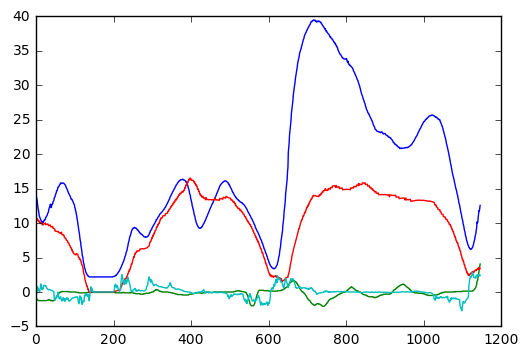

In [4]:
%matplotlib inline
# data_path = "four_scores.csv"
# data_path = "Brightness_features.csv"
# data_path = "obs_data_16d.csv"
# data_path = "ego_data_20d.csv"
data_path = "test_data.csv"
data = read_data(data_path)
data = data[:,3:7]#data[15500:16500,0:1] #data[8000:8500,[0,9]]
n,d = data.shape
plt.figure(1)
plt.plot(range(data.shape[0]),data)
plt.show
# normalize
# for i in range(d):
#     if np.std(data[:,i]) != 0:
#         data[:,i] = (data[:,i]-np.mean(data[:,i]))/np.std(data[:,i])
#     else:
#         data[:,i]    
# plt.figure(2)
# plt.plot(range(data.shape[0]),data)
# plt.show

In [15]:
data_name='MRM_result.pkl'
asd = pkl.load(open(data_name, 'rb'))

In [18]:
asd[0]

{u'action_ego': 0L, u'ego_probs': array([[1],
        [0],
        [0]]), u'frame_id': 448L, u'obs_action': array([ 0.]), u'obs_channel': array([ 0.]), u'obs_id': array([ 0.]), u'obs_probs': array([[1],
        [0],
        [0]]), u'violation_prob': array([[[ 0.50666667,  0.36444444,  0.36444444]],
 
        [[ 0.42222222,  0.40888889,  0.        ]],
 
        [[ 0.        ,  0.        ,  0.36444444]]])}

In [12]:
DP = DirichletProcess(data, max_k=10, kappa = 10, kmeans_init=False)

In [13]:
i = 0
iter_num = 100
while i < iter_num:
    print ("num iter:", i)
    log_likelihood = DP.run()
    i += 1
    print ("log-likelihood:", log_likelihood)
path = DP.get_path()

('num iter:', 0)
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
('log-likelihood:', -16738.553327185313)
('num iter:', 1)
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
state update!
s

ValueError: x and y must have same first dimension

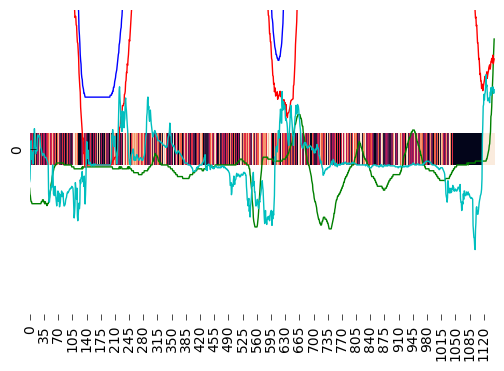

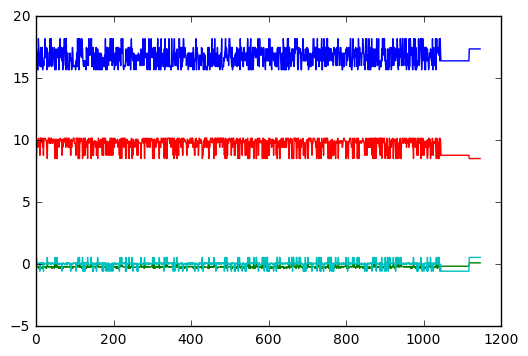

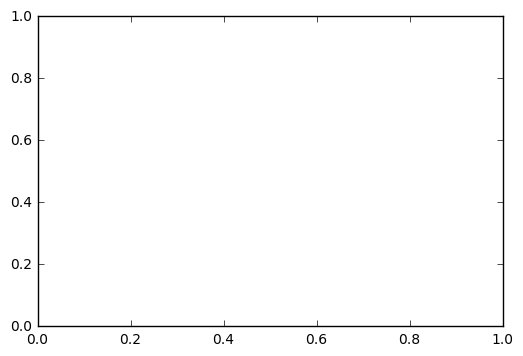

In [14]:
# %matplotlib osx
plt.figure(3)
# sns.heatmap(DP.state[:, 0:1].T, cbar=False)
sns.heatmap(np.reshape(DP.state,(1,DP.n)), cbar=False)
plt.plot(range(data.shape[0]),data)
plt.ylim([-5,5])
plt.figure(4)
plt.plot(range(DP.n),path)
# plt.plot(range(DP.n),path[:,1],'g')
plt.figure(5)
plt.plot(range(200),DP.log_likelihood_list)
plt.show
all_states, state_counts = np.unique(DP.state, return_counts=True)
print("all states: ", all_states)
print("state counts: ", state_counts)

In [21]:
DP.pi

array([[  9.97254488e-001,   2.11656126e-004,   1.11877729e-003,
          1.94125506e-004,   2.25301455e-004,   1.77029762e-004,
          2.11427790e-004,   1.96611834e-004,   1.98752750e-004,
          2.11829066e-004],
       [  2.10287499e-004,   9.97930342e-001,   2.08802820e-004,
          2.13363932e-004,   2.12125557e-004,   2.01807104e-004,
          3.14192514e-004,   1.96965997e-004,   3.10014150e-004,
          2.02098355e-004],
       [  1.55745471e-003,   4.20004714e-004,   9.95239307e-001,
          1.59381957e-010,   2.00565706e-004,   2.73845174e-004,
          1.94926031e-004,   2.64898450e-004,   1.15328008e-003,
          6.95718124e-004],
       [  2.08866500e-004,   4.53496223e-004,   4.14729645e-004,
          9.92102865e-001,   2.68490820e-004,   4.97699393e-003,
          7.35771136e-004,   1.96058424e-004,   1.97013812e-004,
          4.45714262e-004],
       [  2.05147408e-004,   2.37668174e-004,   1.44071985e-003,
          1.99941551e-004,   9.92982867e-00

In [80]:
# plt.figure(1)
# G0 = dirichlet(np.ones(DP.max_k) * (alpha/DP.max_k))
# print (sum(G0))
# for j in range(DP.max_k):
#     plt.plot([j,j],[0,G0[j]])
# plt.show

# plt.figure(2)
# stick_breaking = GEM(alpha)
# G0_new = np.array([next(stick_breaking) for i in range(DP.max_k)]) # the weights of samples.
# print (sum(G0_new))
# for j in range(DP.max_k):
#     plt.plot([j,j],[0,G0_new[j]])
# plt.show


In [13]:
num_states = 0
prev_state = None
for i,state in enumerate(DP.state):
    if prev_state is not None:
        if state != prev_state:
            num_states += 1
    prev_state = state
num_states

183

In [80]:
a = np.array([1.,2.,3.])
q = np.array([3.,4.,5.])
b = []
c = []
b.append(a)
b.append(a)
c.append(q)
c.append(q)
a-c

array([[-2., -2., -2.],
       [-2., -2., -2.]])

In [96]:
np.cov(c, rowvar=False)
# np.mean(a,0)
# a.shape

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [81]:
kmeans2(c,1)

(array([[ 3.,  4.,  5.]]), array([0, 0], dtype=int32))